In [155]:
%%HTML
<style>
  h2 {
    background-color: #2d4f3f;
    color: white !important;
    border-radius: 10px;
    padding: 10px;
    align-items: center;
    justify-content: center;
    text-align: center;
  }
</style>   


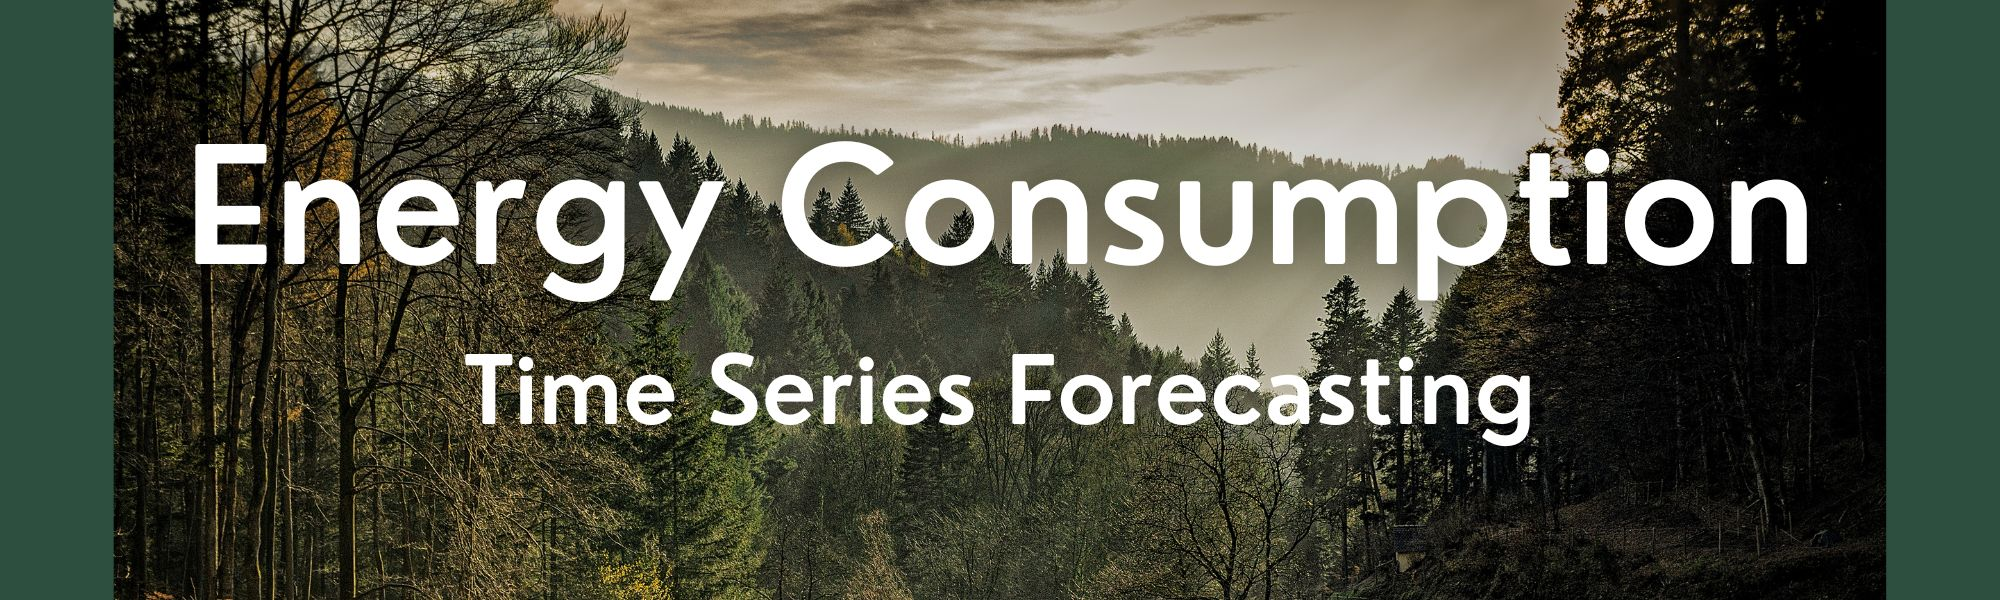

## Overview

Time series forecasting is the process of analyzing time series data to make predictions. The likelihood of forecasts varies, but it remains very useful for providing insights on potential outcomes.

In this project, I'll be using time-series forecasting to predict energy consumption based on hourly energy consumption data from PJM Interconnection LLC. First, I'll take a look at the data and see what trends can be identified, then use xgboost to create a model and assess its validity.

In [156]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


The index is an object type, so I can cast that to datetime which will help the analysis.

In [157]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [158]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


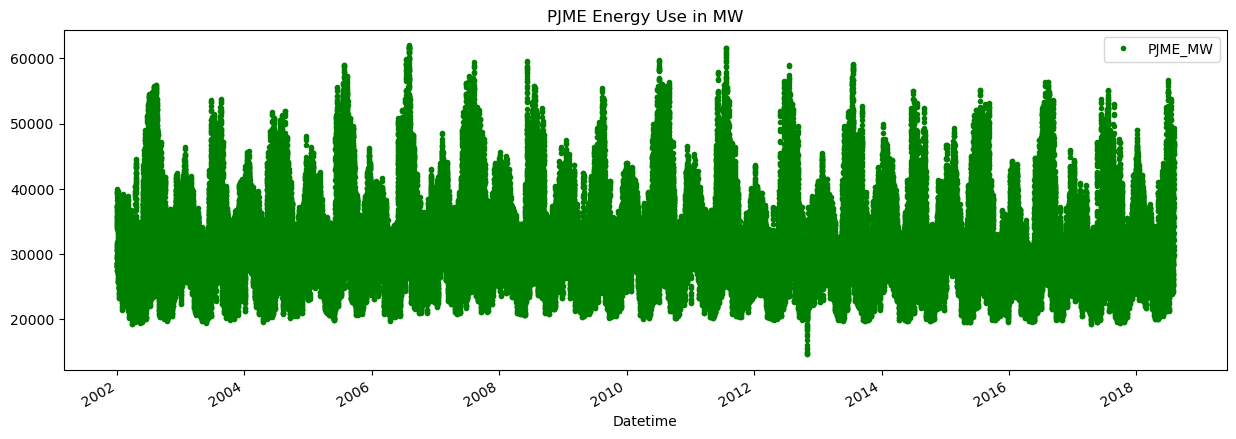

In [159]:
df.plot(style='.',
        figsize=(15, 5),
        color='green',
        title='PJME Energy Use in MW')
plt.show()

## Train/Test Split

I'll split the data at January 2015. Everything prior will be training data, then everything onward will be testing data. This will be visualized below.

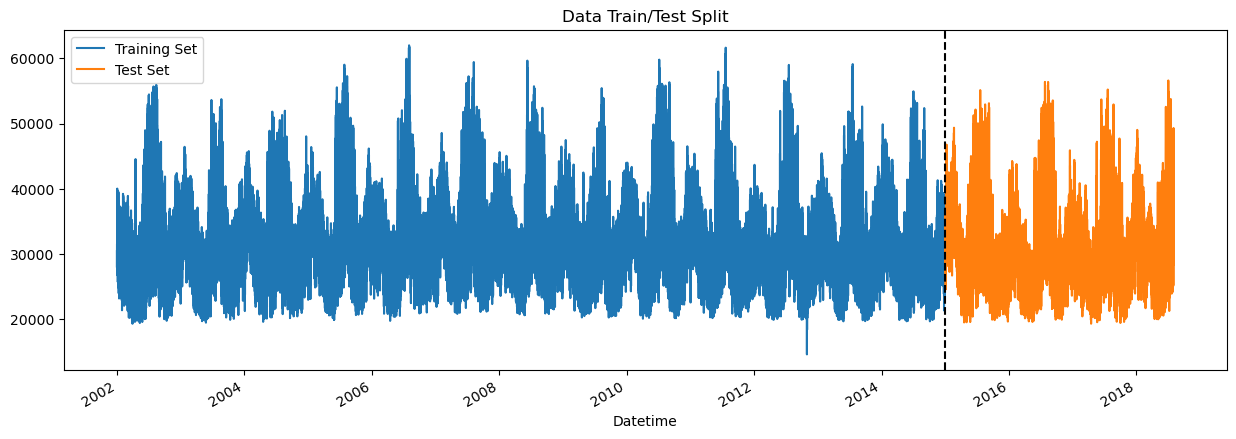

In [160]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

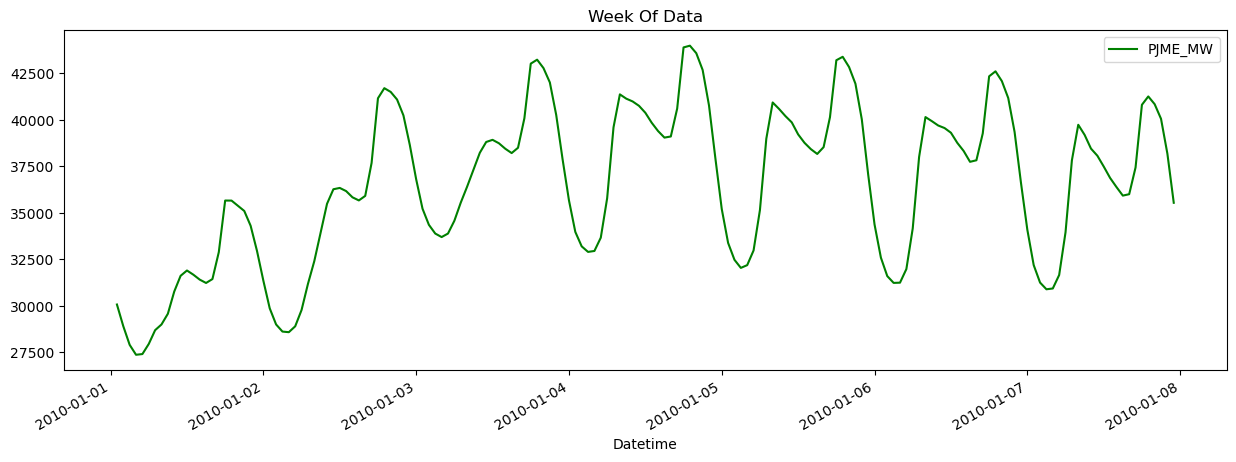

In [161]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data', color='green')
plt.show()

There are two peaks in each day and valleys during nights.

## Feature Creation

In [162]:
df.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='Datetime', length=145366)

In [163]:
def create_features(df):
    """
    Create time series features based on the time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Visualization of Feature/Target Relationship

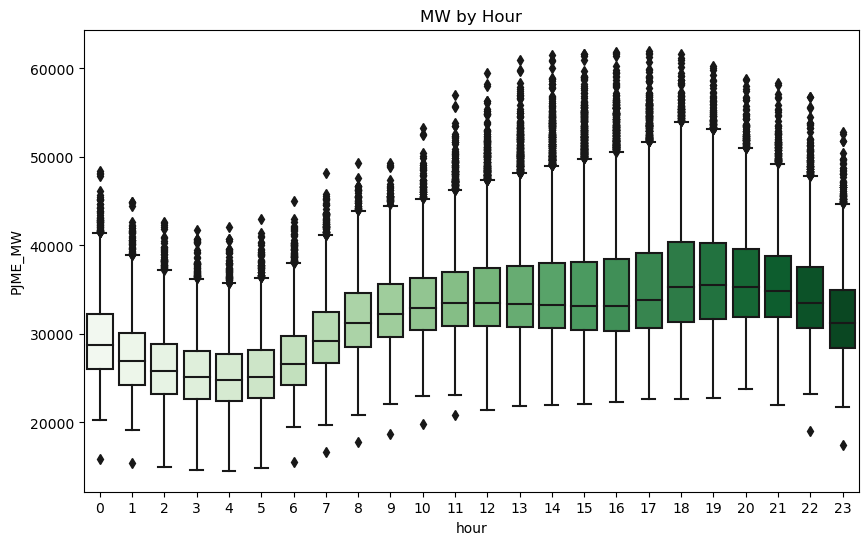

In [164]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette="Greens")
ax.set_title('MW by Hour')
plt.show()

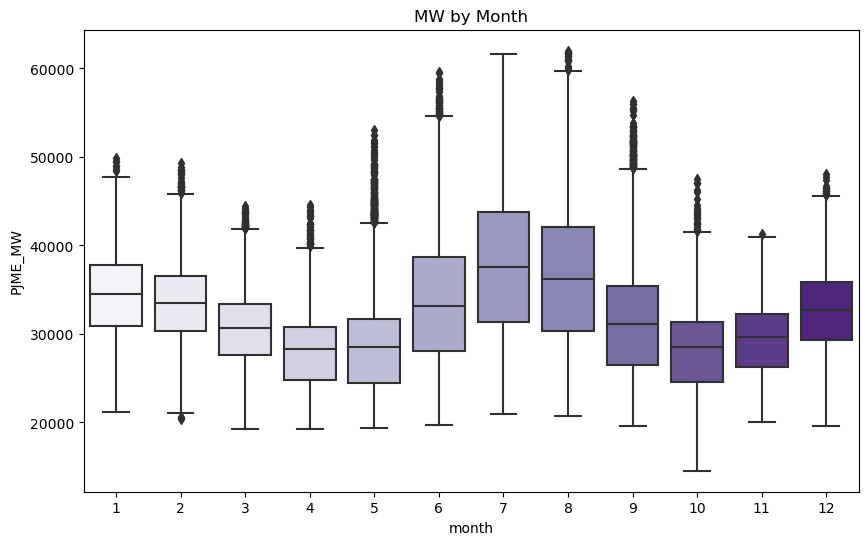

In [165]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Purples')
ax.set_title('MW by Month')
plt.show()

The usage tends to peak twice in the winter season, and there's another peak in the middle of summer.

## Model Creation

In [166]:
train = create_features(train)
test = create_features(test)

In [167]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [168]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [169]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Early stopping rounds and lowering the learning rate will help fight overfitting. 

In [170]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:23:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21576	validation_1-rmse:11743.75117
[200]	validation_0-rmse:5835.12473	validation_1-rmse:5365.67712
[300]	validation_0-rmse:3915.75572	validation_1-rmse:4020.67027
[400]	validation_0-rmse:3443.16487	validation_1-rmse:3853.40425
[500]	validation_0-rmse:3285.33827	validation_1-rmse:3805.30193
[600]	validation_0-rmse:3201.92939	validation_1-rmse:3772.44905
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91088
[800]	validation_0-rmse:3109.24250	validation_1-rmse:3733.89694
[900]	validation_0-rmse:3079.40078	validation_1-rmse:3725.61208
[999]	validation_0-rmse:3052.73502	validation_1-rmse:3722.92243


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

## Feature Importance

Let's examine how much each input variable matters to the target prediction.

In [171]:
reg.feature_importances_

array([0.31852555, 0.17292213, 0.06649727, 0.2859571 , 0.02599414,
       0.13010384], dtype=float32)

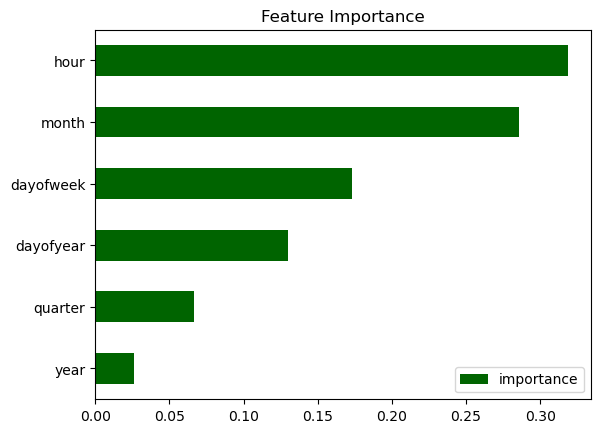

In [172]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', color='Darkgreen')
plt.show()

The target is most impacted by hours and months.

## Forecast on Test Set

In [173]:
reg.predict(X_test)

array([30527.793, 28238.072, 27310.229, ..., 34566.805, 32367.008,
       31172.45 ], dtype=float32)

Numpy array of all the predictions for the test set. Let's store them in a new column and merge this onto the dataframe.

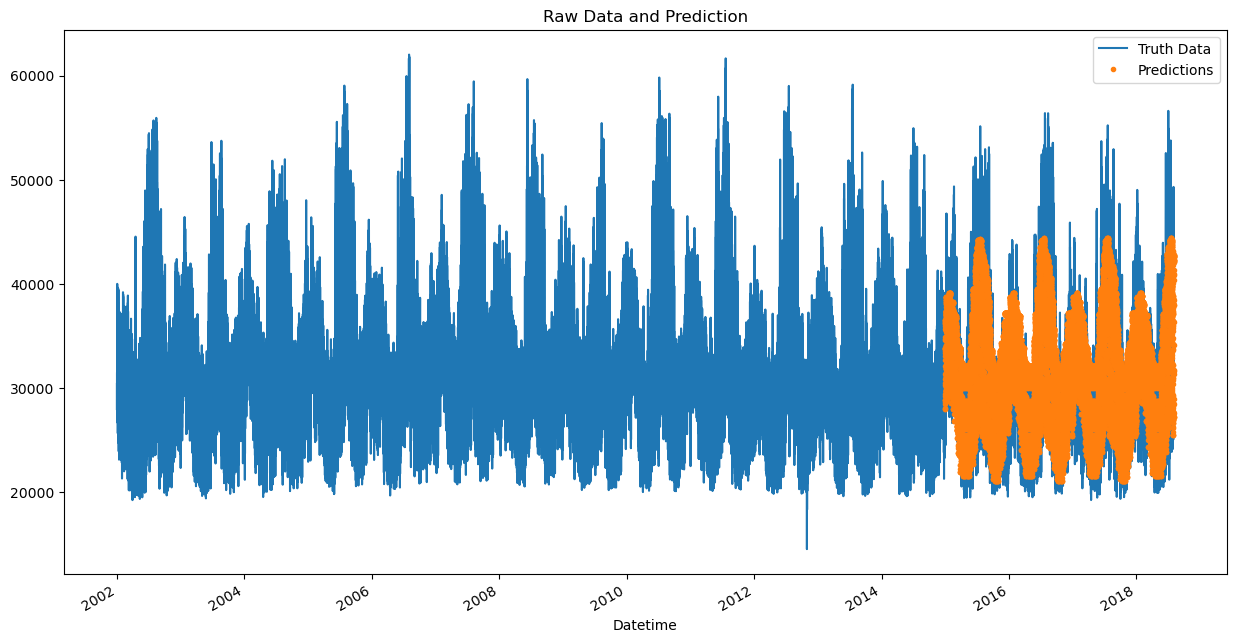

In [174]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 8))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

Above we can see the predictions plotted over the dataset.

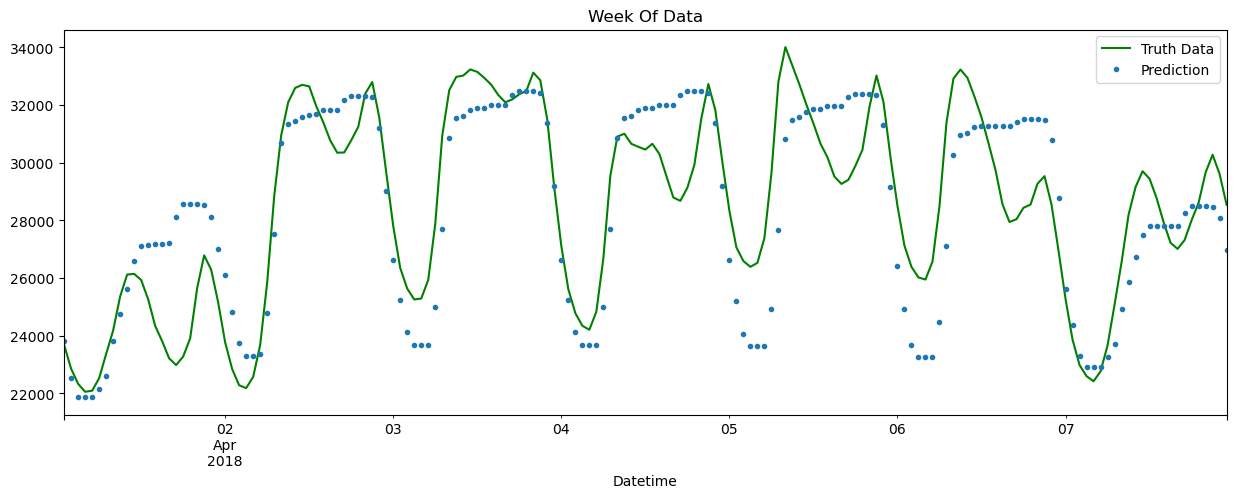

In [175]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data', color='green')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

The predictions do follow the truth data, but there is definitely room for improvement. 

## RMSE Score and Error Calculation

Root mean squared error is the same evaluation used as the model was training. To further improve this model, we would want to be reducing the RMSE score.

In [176]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score for test set: {score:0.2f}')

RMSE Score for test set: 3721.75


Next I'll look at the worst and best predicted days.

In [177]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10) #avg error for each day and sort

date
2016-08-13    12839.595459
2016-08-14    12780.209554
2016-09-10    11356.302002
2015-02-20    10965.976237
2016-09-09    10864.953451
2018-01-06    10506.844889
2016-08-12    10124.050618
2015-02-21     9881.798503
2015-02-16     9781.549805
2018-01-07     9739.143555
Name: error, dtype: float64

The worst predicted days tend to be around August.

In [178]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10) #avg error for each day and sort

date
2017-10-24    349.391520
2015-10-28    397.410563
2016-10-27    528.968994
2015-05-06    529.528483
2017-10-15    535.291748
2018-05-16    585.348470
2016-10-08    625.825521
2015-10-03    653.130697
2016-09-16    656.402588
2015-11-06    674.912516
Name: error, dtype: float64

The best days tend to be in October, with a few in May as well.

## Summary

The model that was built is decent, but could definitely be improved with further knowledge. It would be nice to have more data on weather forecasts and holidays that could be added to the model; this could reduce the RMSE score.

Back to top: [Overview](#Overview)